In [1]:
%matplotlib inline
import scipy as sp
import pysal as ps
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import pyproj
import math
import re
import requests
import bs4
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

/home/emilien/.conda/envs/p35/lib/python3.5/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


Les variables sont décrites dans le fichier : S18007636_toplines.htm

#### Récapitulatif de la réflexion

Réunion le 19/07 avec Julien pour réfléchir autour des données. De son côté, il était intéressé à montrer l'évolution de l'attitude vis-à-vis des essais en fonction de l'apport de connaissance.

Un cadrage général qui s'est dégagé est le suivant : 
- question générale de la participation à la recherche clinique
- constat de l'existence de barrière pour les populations davantage défavorisées (par ex. encadré de VICAN2)
- Comment se construisent ces barrières ? En France, la question des moyens n'est pas central (comparé aux US), ce qui laisse deux grandes catégories : l'accessibilité d'un côté (qui donne lieu à une littérature à part entière) et les attitudes de la participation (par ex. articles sur l'accès)
- Cette attitude peut être découpée en deux grandes catégories : connaissance des essais et de leur intérêt (litteracy) et rapport général au monde médical et à la recherche (attitude)
- Comme hypothèse, nous avons alors : influence de l'attitude au monde médical qui est une autre dimension que la connaissance qui joue dans l'acceptation de la recherche clinique

Le plan de l'article serait 
1. Description de l'acceptabilité
2. Un modèle dual attitude/connaissance
3. Un effet différentiel de la HL suivant la confiance : amplification ?

Dans les questions non résolues :
- robustesse de l'indicateur de litteracy ? autres questions (ex. le besoin d'aide)
- Comment explorer l'incertitude (la fameuse réponse 5 ?)
- attitude envers les essais (biblio) / cf article de Julien 
- Où publier ? : Clinical Research par ex. / Contemporary Clinical Trials

In [2]:
data = pd.read_excel("Data/S18007636_29052018.xlsx")
len(data)

401

Rappel d'éléments sur le sondage:
- bas revenus
- non représentatif


RECTARGET 1 : une personne dans le foyer avec revenus annuels inférieurs à 9000 euros 	128
32%

RECTARGET 2 : DEUX personnes ou plus dans le foyer avec revenus annuels inférieurs à 12000 euros 	273
68%

RECTARGET 3 / personnes dont les revenus annuels sont supérieurs à 9000 euros si seul, ou 12 000 si 2 personnes et plus 	-


Possibilité de construire une échelle de compréhension de la literracy en cancer

### Variables indépendantes

- resp_gender genre
- resp_age age
- QMktSize[{_5}]._1 département
- FRREGION1 département
- FR02REGION2 région
- FRREGIONUDA5 grandes zones
- FRINSEEMKTSIZE type de zone de résidence
- FR02EDU diplome
- HHCMP10 personnes au foyer
- FR01INC revenu


- QEC5 Avez-vous déjà participé ou connaissez-vous quelqu'un qui a déjà participé à un essai clinique ?


### Questions d'intérêt

- QEC0 Avez- vous déjà entendu parler d'essais cliniques ?
- QEC5 Avez-vous déjà participé ou connaissez-vous quelqu'un qui a déjà participé à un essai clinique ?
- QEC6 Qui de vous-même ou de vos connaissances a déjà participé à un essai clinique ?
- QEC7 L'essai clinique avait-il pour but...L'essai clinique avait-il pour but...
- QEC2 D'après ce que vous en savez, quelle est votre impression générale sur les essais cliniques ?
- QEC3 D'après ce que vous en savez, seriez-vous d'accord pour participer à un essai clinique ?
- QEC8 Savez-vous que les différents types d'essais cliniques sont parfois distingués en « Phases » ?
- QDM5 Est-ce que vous-même ou l'un de vos proches travaille ou a travaillé dans le domaine médical ?
- QHL1 Avez-vous besoin d'aide pour lire les documents de l'hôpital ?
- QHL2 Êtes-vous à l'aise pour remplir vous-même un formulaire médical ?
- QT1 Avez-vous confiance dans la médecine telle qu'elle est pratiquée en France ?
- QDM6 Comment est votre état de santé général ?
- QDM9 Bénéficiez-vous de la Couverture Maladie Universelle (CMU) ?

## Exploration de données

### Literacy

- 1 Les essais cliniques sont utiles uniquement en dernier recours – après avoir essayé tous les traitements disponibles###
- 2 Les essais cliniques jouent un rôle très important dans le développement de nouveaux médicaments et traitement
- 3 Les essais cliniques sont suivis de près par les experts dans leurs champs respectifs###
- 4 Les essais cliniques concernent seulement les personnes atteintes de maladie rare###
- 5 Les essais cliniques ne conviennent qu'aux personnes dont le pronostic vital est engagé###
- 6 Les participants aux essais cliniques ne sont que des « cobayes »###
- 7 La plupart des participants aux essais cliniques ne reçoivent pas de nouveau traitement (ils reçoivent en réalité un placebo, c'est-à-dire un traitement inactif)###
- 8 Les essais cliniques donnent de l'espoir aux personnes en leur donnant accès à de nouveaux traitements qu'ils ne pourraient obtenir autrement###

In [3]:
grid_literacy = {
"GRIDQEC4[{1}].QEC4":"Les essais cliniques sont utiles uniquement en dernier recours – après avoir essayé tous les traitements disponibles",
"GRIDQEC4[{2}].QEC4":"Les essais cliniques jouent un rôle très important dans le développement de nouveaux médicaments et traitement",
"GRIDQEC4[{3}].QEC4":"Les essais cliniques sont suivis de près par les experts dans leurs champs respectifs",
"GRIDQEC4[{4}].QEC4":"Les essais cliniques concernent seulement les personnes atteintes de maladie rare",
"GRIDQEC4[{5}].QEC4":"Les essais cliniques ne conviennent qu'aux personnes dont le pronostic vital est engagé",
"GRIDQEC4[{6}].QEC4":"Les participants aux essais cliniques ne sont que des « cobayes »",
"GRIDQEC4[{7}].QEC4":"La plupart des participants aux essais cliniques ne reçoivent pas de nouveau traitement (ils reçoivent en réalité un placebo, c'est-à-dire un traitement inactif)",
"GRIDQEC4[{8}].QEC4":"Les essais cliniques donnent de l'espoir aux personnes en leur donnant accès à de nouveaux traitements qu'ils ne pourraient obtenir autrement"
}

Analysé comme un indicateur de connaissance par rapport aux essais : accurate perception (jolie moyenne de 6.8 pour les US)

Définition des indicateurs de literacy

In [10]:
l = ["GRIDQEC4[{"+str(i)+"}].QEC4" for i in range(1,9)]
def reco(x):
    if pd.isnull(x):
        return None
    else:
        return 11-x
data["literacy_essai"]= data[l[0]]+data[l[1]]+data[l[2]].apply(reco)+data[l[3]].apply(reco)+data[l[4]].apply(reco)+data[l[5]].apply(reco)+data[l[6]].apply(reco)+data[l[7]]
data["literacy_essai"] = data["literacy_essai"]/8

data["literacy_g"] = ((6-data["QHL1"])+data["QHL2"])/2

In [13]:
data.groupby("QALEA2 (1/3)")["literacy_g"].describe()

,count,mean,std,min,25%,50%,75%,max
QALEA2 (1/3),,,,,,,,
1,134.0,3.906716,0.901477,2.0,3.5,4.0,4.5,5.0
2,134.0,4.037313,0.879223,1.5,3.5,4.0,5.0,5.0
3,133.0,4.037594,0.849742,1.0,3.5,4.0,5.0,5.0


In [9]:
data.groupby("resp_gender")["literacy_essai"].describe()

,count,mean,std,min,25%,50%,75%,max
resp_gender,,,,,,,,
female,236.0,6.112288,0.799333,3.375,5.625,6.125,6.75000,8.000
male,132.0,6.129735,0.831226,3.750,5.625,6.000,6.65625,8.375


In [ ]:
#data[["GRIDQEC4[{"+str(i)+"}].QEC4" for i in range(1,9)]]

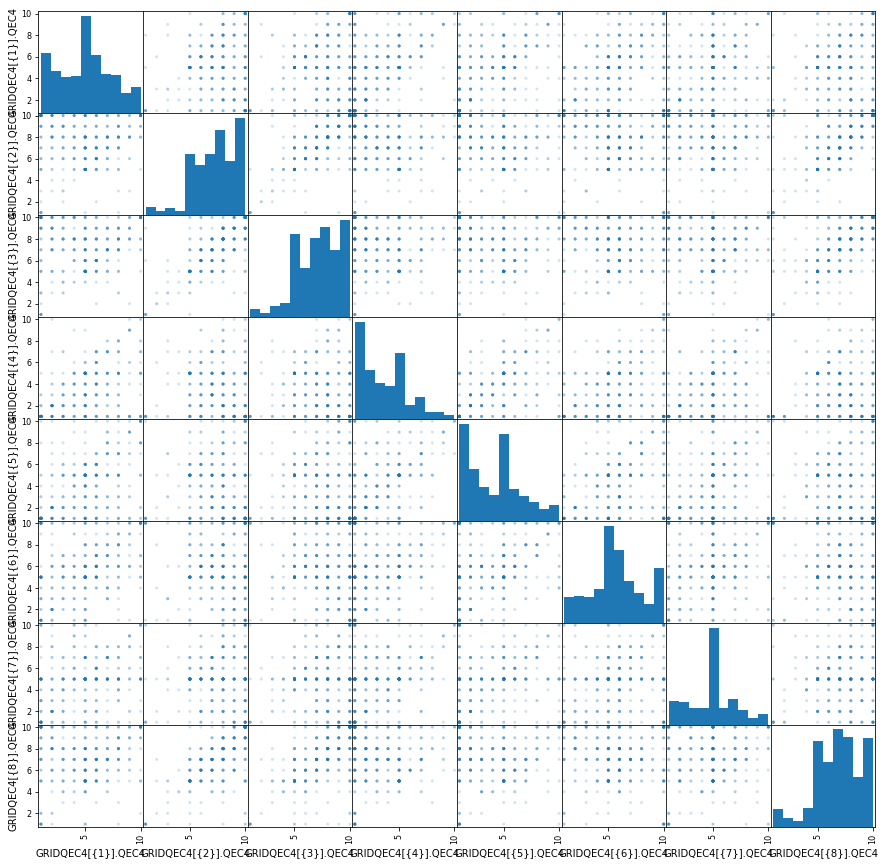

In [154]:
a = pd.plotting.scatter_matrix(df,alpha=0.2,figsize=(15,15))

In [155]:
corr = pd.DataFrame(df).corr()
corr.style.background_gradient()

,GRIDQEC4[{1}].QEC4,GRIDQEC4[{2}].QEC4,GRIDQEC4[{3}].QEC4,GRIDQEC4[{4}].QEC4,GRIDQEC4[{5}].QEC4,GRIDQEC4[{6}].QEC4,GRIDQEC4[{7}].QEC4,GRIDQEC4[{8}].QEC4
GRIDQEC4[{1}].QEC4,1,0.0606116,0.0937107,0.476794,0.50595,0.319955,0.283426,0.140912
GRIDQEC4[{2}].QEC4,0.0606116,1,0.739848,-0.108422,-0.0663335,-0.0790493,0.0196165,0.667388
GRIDQEC4[{3}].QEC4,0.0937107,0.739848,1,-0.078515,-0.0100827,-0.0656928,0.0495192,0.614024
GRIDQEC4[{4}].QEC4,0.476794,-0.108422,-0.078515,1,0.578703,0.234295,0.341073,0.0416865
GRIDQEC4[{5}].QEC4,0.50595,-0.0663335,-0.0100827,0.578703,1,0.316872,0.29411,0.0366089
GRIDQEC4[{6}].QEC4,0.319955,-0.0790493,-0.0656928,0.234295,0.316872,1,0.180944,-0.0504907
GRIDQEC4[{7}].QEC4,0.283426,0.0196165,0.0495192,0.341073,0.29411,0.180944,1,0.118361
GRIDQEC4[{8}].QEC4,0.140912,0.667388,0.614024,0.0416865,0.0366089,-0.0504907,0.118361,1


[ 0.30967232  0.29700489  0.10463062  0.09530337  0.06314229  0.05363415
  0.04556509  0.03104726]


<Container object of 8 artists>

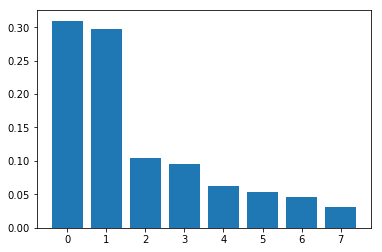

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df = StandardScaler().fit_transform(df)
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4','principal component 5', 'principal component 6', 'principal component 7', 'principal component 8'])
print(pca.explained_variance_ratio_)
plt.bar(range(0,8),pca.explained_variance_ratio_)

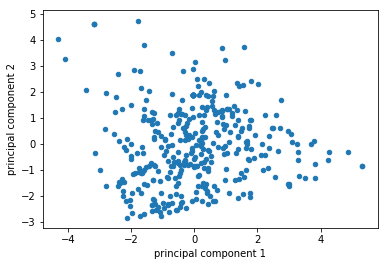

In [157]:
principalDf.plot(kind="scatter",x="principal component 1",y="principal component 2")

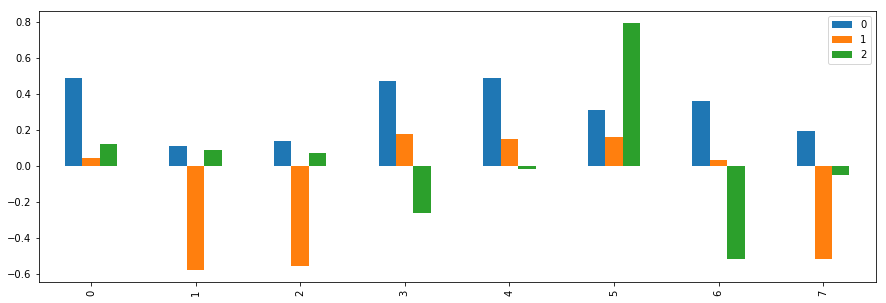

In [165]:
pd.DataFrame(pca.components_).T[[0,1,2]].plot(kind="bar",figsize=(15,5))

### Attitude par rapport aux essais

Si vous envisagiez de participer à un essai clinique, quelle importance accorderiez-vous à chacun des critères suivants, dans votre décision d'y participer ou non ?

de 1 pas du tout important
à 10 extrêmement important

- GRIDQEC14[{1}].QEC14 Vous avez déjà essayé tous les traitements standards disponibles
- GRIDQEC14[{2}].QEC14 Les essais cliniques offrent une alternative à un traitement que vous souhaitez éviter(chirurgie invasive, chimiothérapie, etc.)
- GRIDQEC14[{3}].QEC14 Vous n'êtes pas en mesure de couvrir les frais associés aux autres options thérapeutiques###
- GRIDQEC14[{4}].QEC14 L'essai clinique est proposé dans un centre de renommée mondiale###
- GRIDQEC14[{5}].QEC14 L'essai clinique est proposé dans un hôpital proche de votre domicile###
- GRIDQEC14[{6}].QEC14 En participant, vous favorisez l'avancée des connaissances médicales et des traitements pour les autres malades###
votre médecin vous recommande de participer###
- GRIDQEC14[{7}].QEC14 Vous n'avez pas de frais à payer pour participer à l'essai clinique###
- GRIDQEC14[{8}].QEC14 Vous pouvez bénéficier de meilleurs soins en participant à l'essai clinique###
- GRIDQEC14[{9}].QEC14 Le traitement dont vous souhaitez bénéficier n'est disponible que dans le cadre d'un essai clinique###

In [23]:
grid_attitude = {"GRIDQEC14[{1}].QEC14": "Vous avez déjà essayé tous les traitements standards disponibles",
"GRIDQEC14[{2}].QEC14": "Les essais cliniques offrent une alternative à un traitement que vous souhaitez éviter(chirurgie invasive, chimiothérapie, etc.)",
"GRIDQEC14[{3}].QEC14": "Vous n'êtes pas en mesure de couvrir les frais associés aux autres options thérapeutiques",
"GRIDQEC14[{4}].QEC14": "L'essai clinique est proposé dans un centre de renommée mondiale",
"GRIDQEC14[{5}].QEC14": "L'essai clinique est proposé dans un hôpital proche de votre domicile",
"GRIDQEC14[{6}].QEC14": "En participant, vous favorisez l'avancée des connaissances médicales et des traitements pour les autres malades",
"GRIDQEC14[{7}].QEC14": "Votre médecin vous recommande de participer",
"GRIDQEC14[{8}].QEC14": "Vous n'avez pas de frais à payer pour participer à l'essai clinique",
"GRIDQEC14[{9}].QEC14": "Vous pouvez bénéficier de meilleurs soins en participant à l'essai clinique",
"GRIDQEC14[{10}].QEC14": "Le traitement dont vous souhaitez bénéficier n'est disponible que dans le cadre d'un essai clinique"}

In [174]:
df = data[["GRIDQEC14[{"+str(i)+"}].QEC14" for i in range(1,11)]]

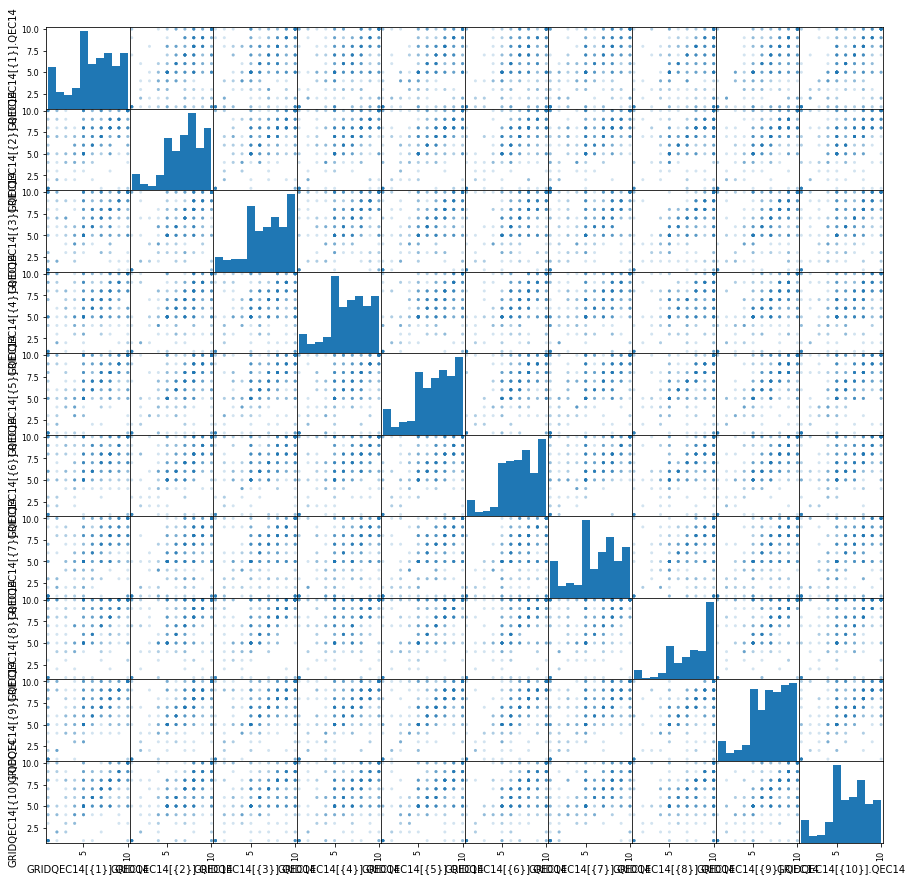

In [6]:
a = pd.plotting.scatter_matrix(df,alpha=0.2,figsize=(15,15))

[ 0.56023898  0.08518565  0.07629616  0.05078056  0.04908596  0.04378776
  0.04129458  0.03520345]


<Container object of 8 artists>

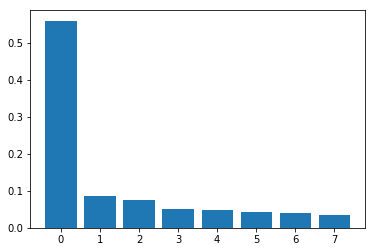

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df = StandardScaler().fit_transform(df)
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4','principal component 5', 'principal component 6', 'principal component 7', 'principal component 8'])
print(pca.explained_variance_ratio_)
plt.bar(range(0,8),pca.explained_variance_ratio_)

In [178]:
df.mean()

GRIDQEC14[{1}].QEC14     6.179551
GRIDQEC14[{2}].QEC14     7.029925
GRIDQEC14[{3}].QEC14     6.917706
GRIDQEC14[{4}].QEC14     6.658354
GRIDQEC14[{5}].QEC14     6.905237
GRIDQEC14[{6}].QEC14     7.124688
GRIDQEC14[{7}].QEC14     6.261845
GRIDQEC14[{8}].QEC14     7.598504
GRIDQEC14[{9}].QEC14     7.017456
GRIDQEC14[{10}].QEC14    6.483791
dtype: float64

In [181]:
df.agg(["mean","std","max","mean"])

,GRIDQEC14[{1}].QEC14,GRIDQEC14[{2}].QEC14,GRIDQEC14[{3}].QEC14,GRIDQEC14[{4}].QEC14,GRIDQEC14[{5}].QEC14,GRIDQEC14[{6}].QEC14,GRIDQEC14[{7}].QEC14,GRIDQEC14[{8}].QEC14,GRIDQEC14[{9}].QEC14,GRIDQEC14[{10}].QEC14
mean,6.179551,7.029925,6.917706,6.658354,6.905237,7.124688,6.261845,7.598504,7.017456,6.483791
std,2.734535,2.336472,2.505137,2.430121,2.531007,2.324740,2.719148,2.482116,2.375330,2.418752
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,6.179551,7.029925,6.917706,6.658354,6.905237,7.124688,6.261845,7.598504,7.017456,6.483791


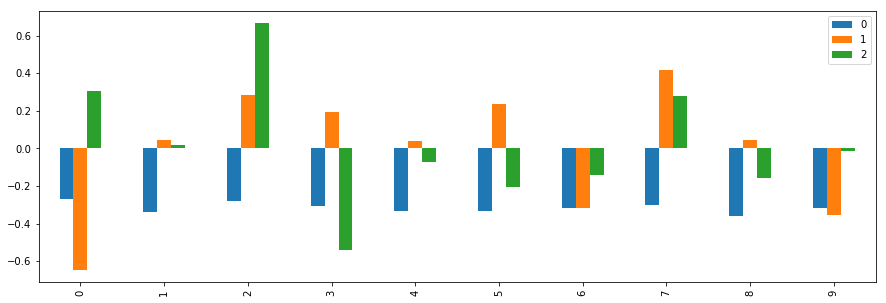

In [171]:
pd.DataFrame(pca.components_).T[[0,1,2]].plot(kind="bar",figsize=(15,5))

In [65]:
corr = df.corr()
corr.style.background_gradient()

,GRIDQEC14[{1}].QEC14,GRIDQEC14[{2}].QEC14,GRIDQEC14[{3}].QEC14,GRIDQEC14[{4}].QEC14,GRIDQEC14[{5}].QEC14,GRIDQEC14[{6}].QEC14,GRIDQEC14[{7}].QEC14,GRIDQEC14[{8}].QEC14,GRIDQEC14[{9}].QEC14,GRIDQEC14[{10}].QEC14
GRIDQEC14[{1}].QEC14,1,0.444051,0.36966,0.312855,0.428696,0.343327,0.522536,0.356139,0.495635,0.542838
GRIDQEC14[{2}].QEC14,0.444051,1,0.551831,0.540736,0.578383,0.601334,0.569341,0.47454,0.631449,0.539338
GRIDQEC14[{3}].QEC14,0.36966,0.551831,1,0.329235,0.481377,0.443918,0.388897,0.559964,0.489694,0.413812
GRIDQEC14[{4}].QEC14,0.312855,0.540736,0.329235,1,0.54751,0.553635,0.506167,0.466688,0.638992,0.44671
GRIDQEC14[{5}].QEC14,0.428696,0.578383,0.481377,0.54751,1,0.565837,0.554675,0.522799,0.617793,0.564934
GRIDQEC14[{6}].QEC14,0.343327,0.601334,0.443918,0.553635,0.565837,1,0.508561,0.558065,0.665122,0.554783
GRIDQEC14[{7}].QEC14,0.522536,0.569341,0.388897,0.506167,0.554675,0.508561,1,0.425291,0.59537,0.549724
GRIDQEC14[{8}].QEC14,0.356139,0.47454,0.559964,0.466688,0.522799,0.558065,0.425291,1,0.579565,0.409707
GRIDQEC14[{9}].QEC14,0.495635,0.631449,0.489694,0.638992,0.617793,0.665122,0.59537,0.579565,1,0.595097
GRIDQEC14[{10}].QEC14,0.542838,0.539338,0.413812,0.44671,0.564934,0.554783,0.549724,0.409707,0.595097,1


### Echelle des préoccupations 

Toujours dans le cas où vous envisageriez de participer à un essai clinique, quelle importance accorderiez- vous à chacune des préoccupations suivantes dans votre décision d'y participer ou non ?

de 1 préoccupation pas du tout importante
à 10 préoccupation extrêmement importante

- GRIDQEC15[{1}].QEC15 Vous ne voulez pas se sentir comme un « cobaye »###
- GRIDQEC15[{2}].QEC15 Vous doutez de l'efficacité des traitements non validés
- GRIDQEC15[{3}].QEC15 Vous vous inquiètez au sujet de la sûreté et des effets secondaires du traitement###
- GRIDQEC15[{4}].QEC15 Vous craignez de recevoir un placebo plutôt que le nouveau traitement###
- GRIDQEC15[{5}].QEC15 Le lieu de l'essai clinique est trop éloigné de votre domicile###
- GRIDQEC15[{6}].QEC15 Vous craignez de ne pas être éligible pour l'essai clinique###
- GRIDQEC15[{7}].QEC15 Vous ne comprenez pas comment les essais cliniques fonctionnent###
- GRIDQEC15[{8}].QEC15 Vous doutez du fait d'être remboursé(e) pour l'ensemble des frais###
- GRIDQEC15[{9}].QEC15 Vous craignez de devoir aller souvent à l'hôpital###
- GRIDQEC15[{10}].QEC15 Vous doutez de la capacité de l'hôpital où se déroule l'essai clinique à fournir des soins d'excellence###
- GRIDQEC15[{11}].QEC15 Vous craignez de devoir passer des examens supplémentaires (examen d'imagerie, prise de sang, etc.)###

In [15]:
grid_preoccupations = {
    
    "GRIDQEC15[{1}].QEC15": "Vous ne voulez pas se sentir comme un « cobaye »",
"GRIDQEC15[{2}].QEC15": "Vous doutez de l'efficacité des traitements non validés",
"GRIDQEC15[{3}].QEC15": "Vous vous inquiètez au sujet de la sûreté et des effets secondaires du traitement",
"GRIDQEC15[{4}].QEC15": "Vous craignez de recevoir un placebo plutôt que le nouveau traitement",
"GRIDQEC15[{5}].QEC15": "Le lieu de l'essai clinique est trop éloigné de votre domicile",
"GRIDQEC15[{6}].QEC15": "Vous craignez de ne pas être éligible pour l'essai clinique",
"GRIDQEC15[{7}].QEC15": "Vous ne comprenez pas comment les essais cliniques fonctionnent",
"GRIDQEC15[{8}].QEC15": "Vous doutez du fait d'être remboursé(e) pour l'ensemble des frais",
"GRIDQEC15[{9}].QEC15": "Vous craignez de devoir aller souvent à l'hôpital",
"GRIDQEC15[{10}].QEC15": "Vous doutez de la capacité de l'hôpital où se déroule l'essai clinique à fournir des soins d'excellence",
"GRIDQEC15[{11}].QEC15": "Vous craignez de devoir passer des examens supplémentaires (examen d'imagerie, prise de sang, etc.)"
    
}

In [188]:
df = data[["GRIDQEC15[{"+str(i)+"}].QEC15" for i in range(1,12)]]

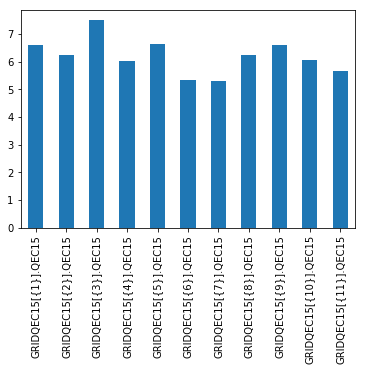

In [191]:
df.mean().plot(kind="bar")

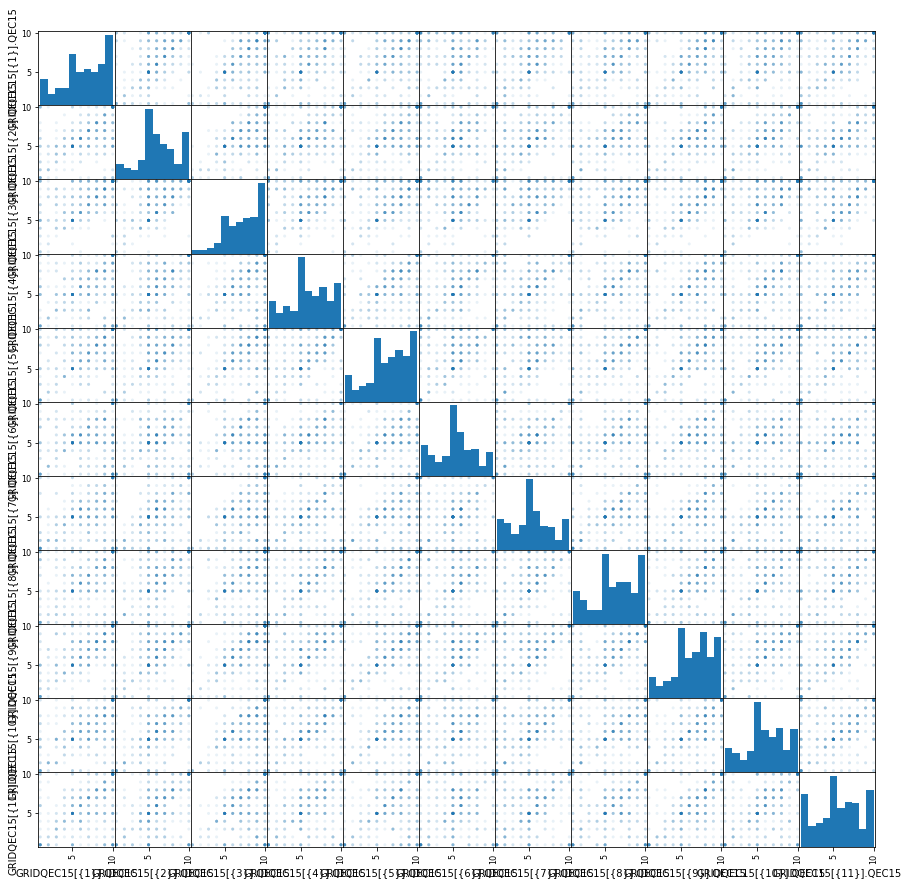

In [105]:
a = pd.plotting.scatter_matrix(df,alpha=0.1,figsize=(15,15))

In [59]:
corr = df.corr()
corr.style.background_gradient()

,GRIDQEC15[{1}].QEC15,GRIDQEC15[{2}].QEC15,GRIDQEC15[{3}].QEC15,GRIDQEC15[{4}].QEC15,GRIDQEC15[{5}].QEC15,GRIDQEC15[{6}].QEC15,GRIDQEC15[{7}].QEC15,GRIDQEC15[{8}].QEC15,GRIDQEC15[{9}].QEC15,GRIDQEC15[{10}].QEC15,GRIDQEC15[{11}].QEC15
GRIDQEC15[{1}].QEC15,1,0.475218,0.524527,0.300393,0.331836,0.0986714,0.412295,0.331596,0.512406,0.458975,0.389068
GRIDQEC15[{2}].QEC15,0.475218,1,0.574813,0.455575,0.391013,0.230113,0.474857,0.4798,0.554275,0.616988,0.442319
GRIDQEC15[{3}].QEC15,0.524527,0.574813,1,0.342372,0.385603,0.0577634,0.392105,0.358165,0.555581,0.47788,0.347424
GRIDQEC15[{4}].QEC15,0.300393,0.455575,0.342372,1,0.395551,0.41581,0.383786,0.418239,0.416607,0.398696,0.366651
GRIDQEC15[{5}].QEC15,0.331836,0.391013,0.385603,0.395551,1,0.337423,0.393531,0.441324,0.500996,0.457559,0.277525
GRIDQEC15[{6}].QEC15,0.0986714,0.230113,0.0577634,0.41581,0.337423,1,0.197652,0.281241,0.22941,0.242236,0.216348
GRIDQEC15[{7}].QEC15,0.412295,0.474857,0.392105,0.383786,0.393531,0.197652,1,0.460334,0.39683,0.484923,0.339091
GRIDQEC15[{8}].QEC15,0.331596,0.4798,0.358165,0.418239,0.441324,0.281241,0.460334,1,0.437399,0.473115,0.284582
GRIDQEC15[{9}].QEC15,0.512406,0.554275,0.555581,0.416607,0.500996,0.22941,0.39683,0.437399,1,0.519625,0.589936
GRIDQEC15[{10}].QEC15,0.458975,0.616988,0.47788,0.398696,0.457559,0.242236,0.484923,0.473115,0.519625,1,0.370737


[ 0.45814363  0.10758668  0.07597444  0.05994911  0.0548984   0.05140066
  0.04871859  0.04573618]


<Container object of 8 artists>

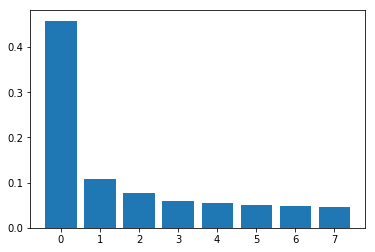

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df = StandardScaler().fit_transform(df)
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4','principal component 5', 'principal component 6', 'principal component 7', 'principal component 8'])
print(pca.explained_variance_ratio_)
plt.bar(range(0,8),pca.explained_variance_ratio_)

In [187]:
pca.components_[0]

array([-0.26724793, -0.33740077, -0.28090685, -0.30378638, -0.33344913,
       -0.33074537, -0.31837071, -0.30149092, -0.35996577, -0.31801191])

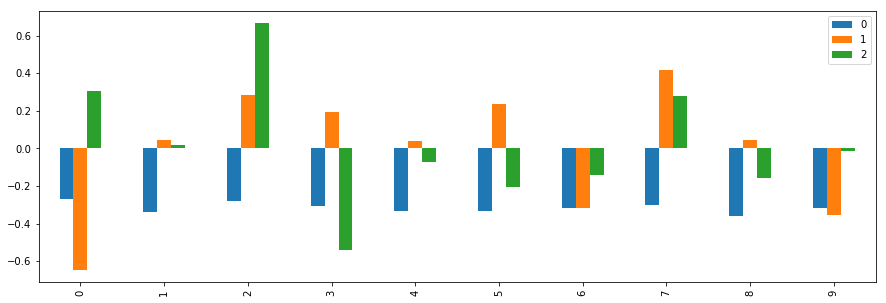

In [186]:
pd.DataFrame(pca.components_).T[[0,1,2]].plot(kind="bar",figsize=(15,5))

[ 0.33236421  0.18881188  0.05393161  0.04337035  0.0383654   0.03575789
  0.03348941  0.02834384]


<Container object of 8 artists>

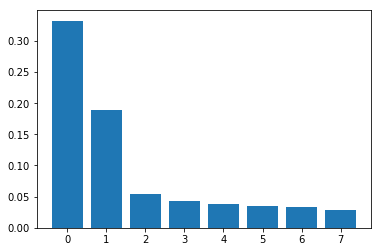

In [103]:
df = data[["GRIDQEC14[{"+str(i)+"}].QEC14" for i in range(1,11)]+["GRIDQEC15[{"+str(i)+"}].QEC15" for i in range(1,12)]]
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df = StandardScaler().fit_transform(df)
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4','principal component 5', 'principal component 6', 'principal component 7', 'principal component 8'])
print(pca.explained_variance_ratio_)
plt.bar(range(0,8),pca.explained_variance_ratio_)

In [64]:
def cronbach_alpha(items):
    items = pd.DataFrame(items)
    items_count = items.shape[1]
    variance_sum = float(items.var(axis=0, ddof=1).sum())
    total_var = float(items.sum(axis=1).var(ddof=1))
    
    return (items_count / float(items_count - 1) *
            (1 - variance_sum / total_var))
alphas = cronbach_alpha(df)
print('Cronbach alpha results: ', alphas)

Cronbach alpha results:  0.8959714615295795


In [ ]:
principalDf.plot(kind="scatter",x="principal component 1",y="principal component 2")

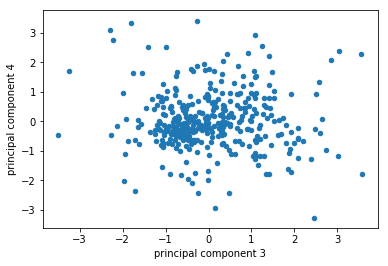

In [37]:
principalDf.plot(kind="scatter",x="principal component 3",y="principal component 4")

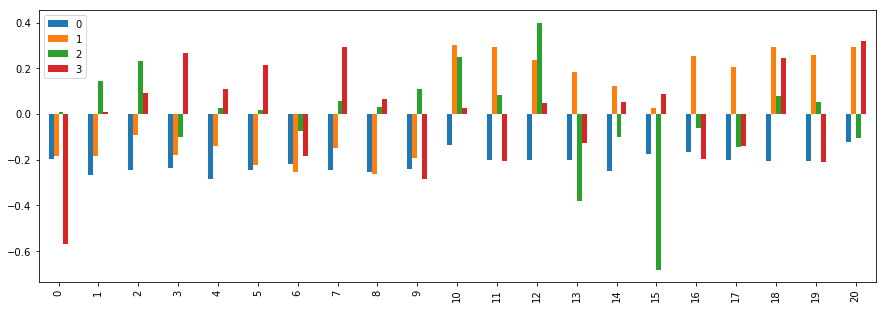

In [36]:
pd.DataFrame(pca.components_).T.plot(kind="bar",figsize=(15,5))

loadings

### Recodage

In [6]:
def reco(df,dic):
    return df.apply(lambda x : dic[x] if x in dic else None)

dic = {1:"oui",2:"non"}

In [7]:
data["QEC8_r"] = reco(data["QEC8"],dic)
data["QDM5_r"] = reco(data["QDM5"],dic)

### Analyse

Variable de connaissance des phases d'essais 

In [8]:
data["QEC8_r"].value_counts()

non    269
oui     99
Name: QEC8_r, dtype: int64

In [90]:
data.groupby("QEC8_r")[l].mean()

,GRIDQEC4[{1}].QEC4,GRIDQEC4[{2}].QEC4,GRIDQEC4[{3}].QEC4,GRIDQEC4[{4}].QEC4,GRIDQEC4[{5}].QEC4,GRIDQEC4[{6}].QEC4,GRIDQEC4[{7}].QEC4,GRIDQEC4[{8}].QEC4
QEC8_r,,,,,,,,
non,5.107807,7.263941,7.074349,3.472119,4.130112,5.732342,4.899628,6.836431
oui,4.575758,8.070707,7.868687,3.383838,3.878788,5.858586,4.989899,7.414141


In [15]:
pd.crosstab(data["QEC8_r"],data["QEC3"])

QEC3,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
QEC8_r,,,,,,,,,,
non,41,18,18,25,58,42,27,14,11,15
oui,11,4,4,6,19,14,10,12,9,10


In [17]:
data.groupby("QEC8_r")[["QEC2","QEC3"]].mean()

,QEC2,QEC3
QEC8_r,,
non,5.550186,4.918216
oui,6.272727,5.868687


In [98]:
data.groupby("confiance")[["QEC2","QEC3"]].mean()

KeyError: 'confiance'

In [192]:
pd.crosstab(data["QEC8_r"],data["resp_gender"]).apply(lambda x: round(100*x/sum(x)))

resp_gender,female,male
QEC8_r,,
non,72.0,76.0
oui,28.0,24.0


In [194]:
pd.crosstab(data["QEC8_r"],data["QDM5_r"]).apply(lambda x: round(100*x/sum(x))) #proche médical

QDM5_r,non,oui
QEC8_r,,
non,77.0,59.0
oui,23.0,41.0


In [202]:
pd.crosstab(data["QEC8_r"],data["FR02EDU"]).apply(lambda x: round(100*x/sum(x))) #niveau d'étude

FR02EDU,1,2,3,4,5,6,7
QEC8_r,,,,,,,
non,67.0,86.0,86.0,73.0,62.0,65.0,61.0
oui,33.0,14.0,14.0,27.0,38.0,35.0,39.0


In [71]:
data["B1"] = data[["GRIDQEC14[{"+str(i)+"}].QEC14" for i in range(1,11)]].apply(lambda x: x.sum(),axis=1)
data["B2"] = data[["GRIDQEC15[{"+str(i)+"}].QEC15" for i in range(1,12)]].apply(lambda x: x.sum(),axis=1)


In [129]:
#data[["GRIDQEC15[{"+str(i)+"}].QEC15" for i in range(1,12)]+["QEC3"]].corr()

In [99]:
def reco(x):
    if pd.isnull(x):
        return None
    if x in [1,2,3]:
        return "Pas confiance"
    return "Confiance"
data["confiance"] =data["QT1"].apply(reco) #3=Parfois

In [123]:
def reco(x):
    if pd.isnull(x):
        return None
    if x == 5 :
        return "NSP"
    if x>5:
        return "Positif"
    return "Négatif"
data["participation"] = data["QEC3"].apply(reco)

In [128]:
pd.crosstab(data["confiance"],data["participation"]).apply(lambda x : x/sum(x),axis=1)

participation,NSP,Négatif,Positif
confiance,,,
Confiance,0.233333,0.271429,0.495238
Pas confiance,0.177215,0.443038,0.379747


In [133]:

pd.crosstab(data["confiance"],data["FR02EDU"]).apply(lambda x : x/sum(x))

FR02EDU,1,2,3,4,5,6,7
confiance,,,,,,,
Confiance,0.666667,0.394737,0.57732,0.560748,0.560606,0.636364,0.5625
Pas confiance,0.333333,0.605263,0.42268,0.439252,0.439394,0.363636,0.4375


In [132]:

pd.crosstab(data["confiance"],data["FR01INC"]).apply(lambda x : x/sum(x))

FR01INC,1,2,3
confiance,,,
Confiance,0.531707,0.581818,0.604651
Pas confiance,0.468293,0.418182,0.395349


In [139]:
pd.crosstab(data["QEC8_r"],data["confiance"]).apply(lambda x : x/sum(x),axis=1)

confiance,Confiance,Pas confiance
QEC8_r,,
non,0.557621,0.442379
oui,0.606061,0.393939


In [147]:
corr = data[["GRIDQEC4[{"+str(i)+"}].QEC4" for i in range(1,8)]+["QT1"]].corr()
corr.style.background_gradient()

,GRIDQEC4[{1}].QEC4,GRIDQEC4[{2}].QEC4,GRIDQEC4[{3}].QEC4,GRIDQEC4[{4}].QEC4,GRIDQEC4[{5}].QEC4,GRIDQEC4[{6}].QEC4,GRIDQEC4[{7}].QEC4,QT1
GRIDQEC4[{1}].QEC4,1,0.0606116,0.0937107,0.476794,0.50595,0.319955,0.283426,-0.0450146
GRIDQEC4[{2}].QEC4,0.0606116,1,0.739848,-0.108422,-0.0663335,-0.0790493,0.0196165,0.418469
GRIDQEC4[{3}].QEC4,0.0937107,0.739848,1,-0.078515,-0.0100827,-0.0656928,0.0495192,0.385212
GRIDQEC4[{4}].QEC4,0.476794,-0.108422,-0.078515,1,0.578703,0.234295,0.341073,-0.0574049
GRIDQEC4[{5}].QEC4,0.50595,-0.0663335,-0.0100827,0.578703,1,0.316872,0.29411,-0.10029
GRIDQEC4[{6}].QEC4,0.319955,-0.0790493,-0.0656928,0.234295,0.316872,1,0.180944,-0.229426
GRIDQEC4[{7}].QEC4,0.283426,0.0196165,0.0495192,0.341073,0.29411,0.180944,1,-0.0240978
QT1,-0.0450146,0.418469,0.385212,-0.0574049,-0.10029,-0.229426,-0.0240978,1


In [148]:
corr = data[["GRIDQEC14[{"+str(i)+"}].QEC14" for i in range(1,10)]+["QT1"]].corr()
corr.style.background_gradient()

,GRIDQEC14[{1}].QEC14,GRIDQEC14[{2}].QEC14,GRIDQEC14[{3}].QEC14,GRIDQEC14[{4}].QEC14,GRIDQEC14[{5}].QEC14,GRIDQEC14[{6}].QEC14,GRIDQEC14[{7}].QEC14,GRIDQEC14[{8}].QEC14,GRIDQEC14[{9}].QEC14,QT1
GRIDQEC14[{1}].QEC14,1,0.444051,0.36966,0.312855,0.428696,0.343327,0.522536,0.356139,0.495635,0.102966
GRIDQEC14[{2}].QEC14,0.444051,1,0.551831,0.540736,0.578383,0.601334,0.569341,0.47454,0.631449,0.185075
GRIDQEC14[{3}].QEC14,0.36966,0.551831,1,0.329235,0.481377,0.443918,0.388897,0.559964,0.489694,0.119638
GRIDQEC14[{4}].QEC14,0.312855,0.540736,0.329235,1,0.54751,0.553635,0.506167,0.466688,0.638992,0.24774
GRIDQEC14[{5}].QEC14,0.428696,0.578383,0.481377,0.54751,1,0.565837,0.554675,0.522799,0.617793,0.225585
GRIDQEC14[{6}].QEC14,0.343327,0.601334,0.443918,0.553635,0.565837,1,0.508561,0.558065,0.665122,0.344528
GRIDQEC14[{7}].QEC14,0.522536,0.569341,0.388897,0.506167,0.554675,0.508561,1,0.425291,0.59537,0.251948
GRIDQEC14[{8}].QEC14,0.356139,0.47454,0.559964,0.466688,0.522799,0.558065,0.425291,1,0.579565,0.232775
GRIDQEC14[{9}].QEC14,0.495635,0.631449,0.489694,0.638992,0.617793,0.665122,0.59537,0.579565,1,0.253451
QT1,0.102966,0.185075,0.119638,0.24774,0.225585,0.344528,0.251948,0.232775,0.253451,1


In [149]:
corr = data[["GRIDQEC15[{"+str(i)+"}].QEC15" for i in range(1,12)]+["QT1"]].corr()
corr.style.background_gradient()

,GRIDQEC15[{1}].QEC15,GRIDQEC15[{2}].QEC15,GRIDQEC15[{3}].QEC15,GRIDQEC15[{4}].QEC15,GRIDQEC15[{5}].QEC15,GRIDQEC15[{6}].QEC15,GRIDQEC15[{7}].QEC15,GRIDQEC15[{8}].QEC15,GRIDQEC15[{9}].QEC15,GRIDQEC15[{10}].QEC15,GRIDQEC15[{11}].QEC15,QT1
GRIDQEC15[{1}].QEC15,1,0.475218,0.524527,0.300393,0.331836,0.0986714,0.412295,0.331596,0.512406,0.458975,0.389068,-0.173804
GRIDQEC15[{2}].QEC15,0.475218,1,0.574813,0.455575,0.391013,0.230113,0.474857,0.4798,0.554275,0.616988,0.442319,-0.187259
GRIDQEC15[{3}].QEC15,0.524527,0.574813,1,0.342372,0.385603,0.0577634,0.392105,0.358165,0.555581,0.47788,0.347424,-0.0941865
GRIDQEC15[{4}].QEC15,0.300393,0.455575,0.342372,1,0.395551,0.41581,0.383786,0.418239,0.416607,0.398696,0.366651,-0.0712656
GRIDQEC15[{5}].QEC15,0.331836,0.391013,0.385603,0.395551,1,0.337423,0.393531,0.441324,0.500996,0.457559,0.277525,0.030195
GRIDQEC15[{6}].QEC15,0.0986714,0.230113,0.0577634,0.41581,0.337423,1,0.197652,0.281241,0.22941,0.242236,0.216348,0.0754968
GRIDQEC15[{7}].QEC15,0.412295,0.474857,0.392105,0.383786,0.393531,0.197652,1,0.460334,0.39683,0.484923,0.339091,-0.0505988
GRIDQEC15[{8}].QEC15,0.331596,0.4798,0.358165,0.418239,0.441324,0.281241,0.460334,1,0.437399,0.473115,0.284582,-0.0688709
GRIDQEC15[{9}].QEC15,0.512406,0.554275,0.555581,0.416607,0.500996,0.22941,0.39683,0.437399,1,0.519625,0.589936,-0.0645775
GRIDQEC15[{10}].QEC15,0.458975,0.616988,0.47788,0.398696,0.457559,0.242236,0.484923,0.473115,0.519625,1,0.370737,-0.260846


5.17391304348


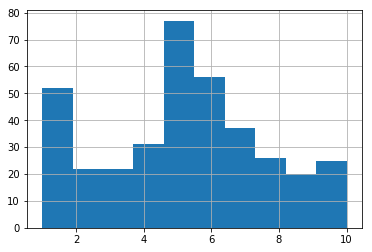

In [210]:
print(data["QEC3"].mean())
data["QEC3"].hist()

5.4114713217


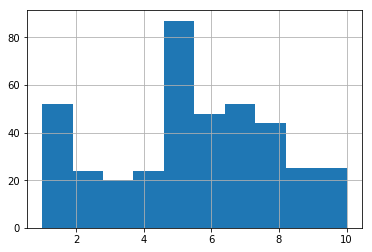

In [209]:
print(data["QEC3B"].mean())
data["QEC3B"].hist()

In [208]:
data[["QEC3","QEC3B"]].corr()

,QEC3,QEC3B
QEC3,1.000000,0.813375
QEC3B,0.813375,1.000000


5.74456521739


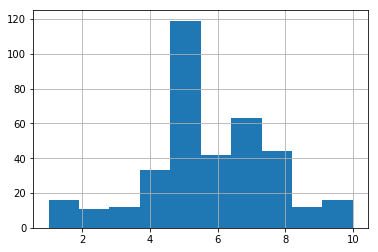

In [211]:
print(data["QEC2"].mean())
data["QEC2"].hist()

6.39152119701


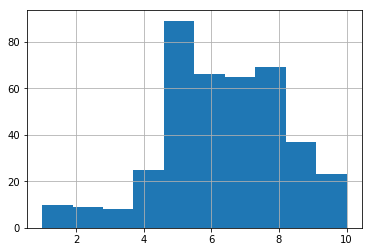

In [212]:
print(data["QEC2B"].mean())
data["QEC2B"].hist()

In [214]:
data.groupby("confiance")[["QEC2","QEC2B","QEC3","QEC3B"]].agg(["mean","median","std"])

QEC2                      QEC2B                       QEC3  \
                   mean median       std      mean median       std      mean   
confiance                                                                       
Confiance      6.228571    6.0  1.836666  6.986667      7  1.743560  5.600000   
Pas confiance  5.101266    5.0  2.103046  5.630682      6  2.101692  4.607595   

                                   QEC3B                   
              median       std      mean median       std  
confiance                                                  
Confiance        5.0  2.566251  5.951111      6  2.596755  
Pas confiance    5.0  2.593071  4.721591      5  2.508680

In [236]:
a = data.groupby("QALEA2 (1/3)")[["QEC2","QEC2B","QEC3","QEC3B"]].agg(["count","mean","median","std"])
a

QEC2                            QEC2B                   \
             count      mean median       std count      mean median   
QALEA2 (1/3)                                                           
1              125  5.592000    5.0  2.129274   134  6.335821      6   
2              122  6.155738    6.0  1.744036   134  6.708955      7   
3              121  5.487603    5.0  2.145211   133  6.127820      6   

                        QEC3                            QEC3B            \
                   std count      mean median       std count      mean   
QALEA2 (1/3)                                                              
1             2.059068   125  4.928000    5.0  2.670556   134  5.335821   
2             1.720398   122  5.795082    6.0  2.428953   134  5.992537   
3             2.227288   121  4.801653    5.0  2.663393   133  4.902256   

                               
             median       std  
QALEA2 (1/3)                   
1                 5  2.741889  
2                 6  2.334753  
3                 5  2.690794

In [235]:
a["QEC2B"]["mean"]-a["QEC2"]["mean"]

QALEA2 (1/3)
1    0.743821
2    0.553218
3    0.640216
Name: mean, dtype: float64

In [237]:
a["QEC3B"]["mean"]-a["QEC3"]["mean"]

QALEA2 (1/3)
1    0.407821
2    0.197455
3    0.100603
Name: mean, dtype: float64

In [108]:
pd.crosstab(data["resp_gender"],data["QALEA2 (1/3)"]).apply(lambda x : x/sum(x))

QALEA2 (1/3),1,2,3
resp_gender,,,
female,0.641791,0.664179,0.601504
male,0.358209,0.335821,0.398496


In [229]:
data.groupby("QALEA2 (1/3)")["HHCMP10"].mean()

QALEA2 (1/3)
1    2.231343
2    2.328358
3    2.330827
Name: HHCMP10, dtype: float64

In [59]:
data.groupby("literacy_r")["QEC2"].mean()

literacy_r
Moins    5.355191
Plus     6.129730
Name: QEC2, dtype: float64

In [58]:
data.groupby("literacy_r")["QEC3"].mean()

literacy_r
Moins    4.775956
Plus     5.567568
Name: QEC3, dtype: float64

# 1. Description du rapport aux essais

La question que traite l'article est la confiance dans les essais et la volonté d'y participer du quartile inférieur de la population française

Résultats soulignés :
- Globalement une faible connaissance
- Des dimensions plus ou moins clivantes 
- Beaucoup d'incertitude ?

QEC0 Avez- vous déjà entendu parler d'essais cliniques ?

In [273]:
t = data["QEC0"].value_counts().sort_index() #1=jamais
print("Connaissent bien : %f" % ((t[4] + t[5])/t.sum()))
t

Connaissent bien : 0.104738


1     33
2    193
3    133
4     26
5     16
Name: QEC0, dtype: int64

QEC5 Avez-vous déjà participé ou connaissez-vous quelqu'un qui a déjà participé à un essai clinique ?

In [277]:
t = data["QEC5"].value_counts().sort_index() #1=Oui ; 3=NSP
print("A participé : %f" % ((t[1])/t.sum()))
t

A participé : 0.084239


1.0     31
2.0    320
3.0     17
Name: QEC5, dtype: int64

### Literacy essais

In [300]:
grid_literacy["literacy_essai"]=". Indicateur moyen"
df = pd.DataFrame([[grid_literacy[i],round(data[i].mean(),1),data[i].median(),data[i].std()] for i in grid_literacy])
df = df.set_index(0)
df.columns = ["Moyenne","Médiane","Std"]
df.sort_index()

,Moyenne,Médiane,Std
0,,,
. Indicateur moyen,6.1,6.125,0.809830
"La plupart des participants aux essais cliniques ne reçoivent pas de nouveau traitement (ils reçoivent en réalité un placebo, c'est-à-dire un traitement inactif)",4.9,5.000,2.278839
Les essais cliniques concernent seulement les personnes atteintes de maladie rare,3.4,3.000,2.277134
Les essais cliniques donnent de l'espoir aux personnes en leur donnant accès à de nouveaux traitements qu'ils ne pourraient obtenir autrement,7.0,7.000,2.220155
Les essais cliniques jouent un rôle très important dans le développement de nouveaux médicaments et traitement,7.5,8.000,2.100906
Les essais cliniques ne conviennent qu'aux personnes dont le pronostic vital est engagé,4.1,4.000,2.621210
Les essais cliniques sont suivis de près par les experts dans leurs champs respectifs,7.3,8.000,2.126431
Les essais cliniques sont utiles uniquement en dernier recours – après avoir essayé tous les traitements disponibles,5.0,5.000,2.594556
Les participants aux essais cliniques ne sont que des « cobayes »,5.8,6.000,2.520706


Savez-vous que les différents types d'essais cliniques sont parfois distingués en « Phases » ?

In [279]:
t = data["QEC8"].value_counts().sort_index() #1=Oui ; 3=NSP
print("Connait les phases : %f" % ((t[1])/t.sum()))
t

Connait les phases : 0.269022


1.0     99
2.0    269
Name: QEC8, dtype: int64

### Attitude générale

In [251]:
df = pd.DataFrame([[grid_attitude[i],round(data[i].mean(),1),data[i].median(),data[i].std()] for i in grid_attitude])
df = df.set_index(0)
df.columns = ["Moyenne","Médiane","Std"]
df

,Moyenne,Médiane,Std
0,,,
L'essai clinique est proposé dans un centre de renommée mondiale,6.7,7.0,2.430121
"En participant, vous favorisez l'avancée des connaissances médicales et des traitements pour les autres malades",7.1,7.0,2.324740
L'essai clinique est proposé dans un hôpital proche de votre domicile,6.9,7.0,2.531007
Vous pouvez bénéficier de meilleurs soins en participant à l'essai clinique,7.0,7.0,2.375330
Votre médecin vous recommande de participer,6.3,7.0,2.719148
Le traitement dont vous souhaitez bénéficier n'est disponible que dans le cadre d'un essai clinique,6.5,7.0,2.418752
Vous avez déjà essayé tous les traitements standards disponibles,6.2,6.0,2.734535
Vous n'avez pas de frais à payer pour participer à l'essai clinique,7.6,8.0,2.482116
Vous n'êtes pas en mesure de couvrir les frais associés aux autres options thérapeutiques,6.9,7.0,2.505137


L'absence de frais (économique), l'alternative, l'amélioration des soins et la participation à l'amélioration des connaissances ressortent. L'épuisement des options à l'inverse est moins un facteur

## Préoccupations

In [ ]:
"QALEA2 (1/3)"

In [261]:
df = pd.DataFrame([[grid_preoccupations[i],round(data[i].mean(),1),data[i].median(),data[i].std()] for i in grid_preoccupations])
df = df.set_index(0)
df.columns = ["Moyenne","Médiane","Std"]
df

,Moyenne,Médiane,Std
0,,,
Vous doutez du fait d'être remboursé(e) pour l'ensemble des frais,6.2,6.0,2.840570
Vous craignez de ne pas être éligible pour l'essai clinique,5.3,5.0,2.553978
Vous ne comprenez pas comment les essais cliniques fonctionnent,5.3,5.0,2.656540
Vous doutez de l'efficacité des traitements non validés,6.2,6.0,2.469088
Vous ne voulez pas se sentir comme un « cobaye »,6.6,7.0,2.806574
Le lieu de l'essai clinique est trop éloigné de votre domicile,6.6,7.0,2.682749
Vous craignez de recevoir un placebo plutôt que le nouveau traitement,6.0,6.0,2.692061
Vous vous inquiètez au sujet de la sûreté et des effets secondaires du traitement,7.5,8.0,2.258398
Vous craignez de devoir aller souvent à l'hôpital,6.6,7.0,2.534138


La sûreté est le facteur le plus important. La connaissance et l'incertitude de participer les moins

## Les représentations sur les essais

## Description de la HL de la population

# 2. Le modèle dual de la HL et de la confiance 

La variable à régresser : la confiance QEC2 / la participation QEC3

Deux hypothèses : différentes formes de litteracy  / effet de la confiance spécifique

Pour chaque variable QEC2 / QEC3 : 
- Modèle 1 : FR01INC revenu, FR02EDU diplome, resp_gender genre, resp_age age
- Modèle 2 : + littéracie générale
- Modèle 3 : + littéracie essai
- Modèle 4 : + connaissance du découpage en phase
- Modèle 5 : + confiance

### Création des variables

In [145]:
data["Impression"] = data["QEC2"].apply(lambda x: 1 if x>5 else 0)
data["Participation"] = data["QEC3"].apply(lambda x: 1 if x>5 else 0)

In [190]:
data["literacy_essai"] = pd.cut(data["literacy1"],data["literacy1"].quantile([0,0.25,0.5,0.75,1]))
data["literacy_g_r"] = data["literacy_g"].apply(lambda x : "Bonne" if x>=4 else "Mauvaise")

In [144]:
def reco(x):
    if x in [1,2,3]:
        return "Inf"
    if x in [4,5]:
        return "Moy"
    if x in [6,7]:
        return "Sup"
data["educC"] = data["FR02EDU"].apply(reco)
data["ageC"] = pd.cut(data["respage"],bins=data["respage"].quantile([0,0.25,0.5,0.75,1]))

In [194]:
def reco(x):
    if x in [1,2]:
        return "Non"
    if x in [3]:
        return "Plutôt"
    if x in [4,5]:
        return "Oui"
data["Confiance"] = data["QT1"].apply(reco)

### Modèle 1
FR01INC revenu, FR02EDU diplome, resp_gender genre, resp_age age

In [179]:
y, X = dmatrices('Impression ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) ',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df = np.exp(r.conf_int())
df['OR'] = np.exp(r.params)
df["P"] = round(r.pvalues,2)
df["OR [IC]"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df = df[["OR [IC]","P"]]
df.columns = ['Impression OR [IC]',"Impression P"]

y, X = dmatrices('Participation ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df_p = np.exp(r.conf_int())
df_p['OR'] = np.exp(r.params)
df_p["P"] = round(r.pvalues,2)
df_p["OR [IC]"] = df_p.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df_p = df_p[["OR [IC]","P"]]
df_p.columns = ['Participation OR [IC]',"Participation P"]



df = df.join(df_p, how = 'left')
df

Optimization terminated successfully.
         Current function value: 0.682068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664900
         Iterations 4


,Impression OR [IC],Impression P,Participation OR [IC],Participation P
Intercept,0.69 [0.34-1.41],0.31,0.37 [0.18-0.77],0.01
"C(ageC)[T.Interval(27.0, 41.0, closed='right')]",0.87 [0.49-1.55],0.64,1.61 [0.90-2.87],0.11
"C(ageC)[T.Interval(41.0, 53.0, closed='right')]",1.06 [0.58-1.94],0.86,1.09 [0.59-2.03],0.78
"C(ageC)[T.Interval(53.0, 65.0, closed='right')]",0.87 [0.47-1.62],0.67,0.96 [0.51-1.80],0.90
C(resp_gender)[T.male],1.00 [0.65-1.52],0.99,0.96 [0.63-1.48],0.86
C(FR01INC)[T.2],1.45 [0.90-2.33],0.12,1.02 [0.63-1.65],0.94
C(FR01INC)[T.3],1.06 [0.63-1.80],0.82,1.12 [0.66-1.90],0.69
C(educC)[T.Moy],1.17 [0.73-1.86],0.52,1.56 [0.97-2.51],0.07
C(educC)[T.Sup],1.17 [0.64-2.12],0.61,1.70 [0.93-3.11],0.09
C(QDM5)[T.2],0.97 [0.58-1.62],0.91,1.23 [0.73-2.07],0.45


### Modèle 2
Modèle 1 : + littéracie générale

-> Pas d'effet spécifique

In [189]:
y, X = dmatrices('Impression ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_g_r)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df = np.exp(r.conf_int())
df['OR'] = np.exp(r.params)
df["P"] = round(r.pvalues,2)
df["OR [IC]"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df = df[["OR [IC]","P"]]
df.columns = ['Impression OR [IC]',"Impression P"]

y, X = dmatrices('Participation ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_g_r)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df_p = np.exp(r.conf_int())
df_p['OR'] = np.exp(r.params)
df_p["P"] = round(r.pvalues,2)
df_p["OR [IC]"] = df_p.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df_p = df_p[["OR [IC]","P"]]
df_p.columns = ['Participation OR [IC]',"Participation P"]



df = df.join(df_p, how = 'left')
df

Optimization terminated successfully.
         Current function value: 0.681562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662447
         Iterations 4


,Impression OR [IC],Impression P,Participation OR [IC],Participation P
Intercept,0.75 [0.38-1.51],0.42,0.56 [0.28-1.14],0.11
"C(ageC)[T.Interval(27.0, 41.0, closed='right')]",0.85 [0.48-1.52],0.59,1.55 [0.87-2.78],0.14
"C(ageC)[T.Interval(41.0, 53.0, closed='right')]",1.02 [0.55-1.88],0.96,1.02 [0.54-1.91],0.95
"C(ageC)[T.Interval(53.0, 65.0, closed='right')]",0.84 [0.45-1.57],0.59,0.90 [0.47-1.70],0.74
C(resp_gender)[T.male],1.01 [0.66-1.54],0.96,1.02 [0.66-1.56],0.95
C(FR01INC)[T.2],1.45 [0.90-2.32],0.13,1.01 [0.62-1.64],0.96
C(FR01INC)[T.3],1.06 [0.63-1.78],0.84,1.12 [0.66-1.91],0.66
C(educC)[T.Moy],1.14 [0.71-1.83],0.58,1.48 [0.91-2.39],0.11
C(educC)[T.Sup],1.15 [0.63-2.08],0.65,1.57 [0.86-2.88],0.14
C(literacy_g_r)[T.Mauvaise],0.87 [0.58-1.32],0.52,0.71 [0.47-1.08],0.11


### Modèle 3
Modèle 2 + littéracie essai

In [191]:
y, X = dmatrices('Impression ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df = np.exp(r.conf_int())
df['OR'] = np.exp(r.params)
df["P"] = round(r.pvalues,2)
df["OR [IC]"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df = df[["OR [IC]","P"]]
df.columns = ['Impression OR [IC]',"Impression P"]

y, X = dmatrices('Participation ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df_p = np.exp(r.conf_int())
df_p['OR'] = np.exp(r.params)
df_p["P"] = round(r.pvalues,2)
df_p["OR [IC]"] = df_p.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df_p = df_p[["OR [IC]","P"]]
df_p.columns = ['Participation OR [IC]',"Participation P"]



df = df.join(df_p, how = 'left')
df

Optimization terminated successfully.
         Current function value: 0.676867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661013
         Iterations 5


,Impression OR [IC],Impression P,Participation OR [IC],Participation P
Intercept,0.55 [0.28-1.10],0.09,0.33 [0.16-0.66],0.00
"C(ageC)[T.Interval(27.0, 41.0, closed='right')]",0.83 [0.46-1.53],0.56,1.61 [0.87-2.97],0.13
"C(ageC)[T.Interval(41.0, 53.0, closed='right')]",1.07 [0.56-2.02],0.84,1.13 [0.59-2.17],0.71
"C(ageC)[T.Interval(53.0, 65.0, closed='right')]",0.88 [0.46-1.68],0.70,0.97 [0.50-1.88],0.94
C(resp_gender)[T.male],1.07 [0.69-1.67],0.76,1.03 [0.66-1.61],0.90
C(FR01INC)[T.2],1.47 [0.89-2.42],0.13,1.01 [0.61-1.68],0.97
C(FR01INC)[T.3],1.01 [0.59-1.75],0.96,1.09 [0.63-1.90],0.76
C(educC)[T.Moy],1.05 [0.64-1.71],0.86,1.43 [0.87-2.37],0.16
C(educC)[T.Sup],0.99 [0.53-1.85],0.98,1.43 [0.76-2.69],0.27
"C(literacy_essai)[T.Interval(5.625, 6.125, closed='right')]",1.61 [0.92-2.83],0.10,1.62 [0.91-2.87],0.10


### Modèle 4
Modèle 3 + littéracie phases 

In [193]:
y, X = dmatrices('Impression ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai) + C(QEC8)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df = np.exp(r.conf_int())
df['OR'] = np.exp(r.params)
df["P"] = round(r.pvalues,2)
df["OR [IC]"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df = df[["OR [IC]","P"]]
df.columns = ['Impression OR [IC]',"Impression P"]

y, X = dmatrices('Participation ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai) + C(QEC8)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df_p = np.exp(r.conf_int())
df_p['OR'] = np.exp(r.params)
df_p["P"] = round(r.pvalues,2)
df_p["OR [IC]"] = df_p.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df_p = df_p[["OR [IC]","P"]]
df_p.columns = ['Participation OR [IC]',"Participation P"]



df = df.join(df_p, how = 'left')
df

Optimization terminated successfully.
         Current function value: 0.667332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654856
         Iterations 5


,Impression OR [IC],Impression P,Participation OR [IC],Participation P
Intercept,0.87 [0.40-1.87],0.71,0.46 [0.21-1.01],0.05
"C(ageC)[T.Interval(27.0, 41.0, closed='right')]",0.91 [0.49-1.67],0.75,1.74 [0.93-3.23],0.08
"C(ageC)[T.Interval(41.0, 53.0, closed='right')]",1.21 [0.63-2.31],0.57,1.25 [0.65-2.43],0.50
"C(ageC)[T.Interval(53.0, 65.0, closed='right')]",0.97 [0.50-1.88],0.93,1.06 [0.54-2.07],0.87
C(resp_gender)[T.male],1.10 [0.70-1.73],0.67,1.05 [0.67-1.66],0.82
C(FR01INC)[T.2],1.57 [0.95-2.61],0.08,1.07 [0.64-1.78],0.80
C(FR01INC)[T.3],1.02 [0.58-1.77],0.95,1.10 [0.63-1.92],0.74
C(educC)[T.Moy],0.95 [0.57-1.57],0.84,1.33 [0.80-2.21],0.27
C(educC)[T.Sup],0.91 [0.48-1.71],0.76,1.33 [0.70-2.54],0.38
"C(literacy_essai)[T.Interval(5.625, 6.125, closed='right')]",1.60 [0.91-2.83],0.10,1.61 [0.90-2.87],0.11


### Modèle 5
Modèle 4 + confiance

Effet sur l'impression, et sur la participation

In [196]:
y, X = dmatrices('Impression ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai) + C(QEC8) + C(Confiance)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df = np.exp(r.conf_int())
df['OR'] = np.exp(r.params)
df["P"] = round(r.pvalues,2)
df["OR [IC]"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df = df[["OR [IC]","P"]]
df.columns = ['Impression OR [IC]',"Impression P"]

y, X = dmatrices('Participation ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai) + C(QEC8) + C(Confiance)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df_p = np.exp(r.conf_int())
df_p['OR'] = np.exp(r.params)
df_p["P"] = round(r.pvalues,2)
df_p["OR [IC]"] = df_p.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df_p = df_p[["OR [IC]","P"]]
df_p.columns = ['Participation OR [IC]',"Participation P"]



df = df.join(df_p, how = 'left')
df

Optimization terminated successfully.
         Current function value: 0.641543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649998
         Iterations 5


,Impression OR [IC],Impression P,Participation OR [IC],Participation P
Intercept,0.29 [0.10-0.86],0.03,0.30 [0.11-0.84],0.02
"C(ageC)[T.Interval(27.0, 41.0, closed='right')]",0.98 [0.52-1.83],0.94,1.81 [0.97-3.38],0.06
"C(ageC)[T.Interval(41.0, 53.0, closed='right')]",1.24 [0.64-2.43],0.52,1.27 [0.65-2.46],0.49
"C(ageC)[T.Interval(53.0, 65.0, closed='right')]",0.93 [0.47-1.84],0.84,1.04 [0.53-2.04],0.91
C(resp_gender)[T.male],1.03 [0.65-1.64],0.90,1.02 [0.64-1.61],0.94
C(FR01INC)[T.2],1.49 [0.89-2.51],0.13,1.03 [0.62-1.73],0.90
C(FR01INC)[T.3],0.89 [0.50-1.57],0.69,1.04 [0.59-1.83],0.90
C(educC)[T.Moy],0.97 [0.58-1.63],0.91,1.34 [0.80-2.24],0.26
C(educC)[T.Sup],0.84 [0.44-1.62],0.61,1.29 [0.68-2.48],0.44
"C(literacy_essai)[T.Interval(5.625, 6.125, closed='right')]",1.55 [0.86-2.79],0.14,1.57 [0.87-2.81],0.13


A partir des modèles, on conclue que :
- pas d'effet de la HL générale
- un effet similaire de la literacy spé. des essais, avec un effet > sur la participation. Cependant, celle-ci apparaît être pluridimensionnelle (question sur la connaissances des phases)
- un effet de la confiance à la fois sur l'impression et la participation indépendamment de la connaissance des essais, avec un effet majeur sur l'impression

# 3. Effet multiplicateur de la confiance

## Evolution générale sur population entière

In [206]:
print(data["QEC2"].mean(),data["QEC2B"].mean(),data["QEC2B"].mean()-data["QEC2"].mean())
print(data["QEC3"].mean(),data["QEC3B"].mean(),data["QEC3B"].mean()-data["QEC3"].mean())

5.74456521739 6.39152119701 0.646955979616
5.17391304348 5.4114713217 0.237558278217


## Evolution en fonction des catégories

#### Literacy générale

In [238]:
t = data.groupby("literacy")[["QEC2","QEC2B","QEC3","QEC3B"]].mean()
t["D2"] = t["QEC2B"]-t["QEC2"]
t["D3"] = t["QEC3B"]-t["QEC3"]
t

,QEC2,QEC2B,QEC3,QEC3B,D2,D3
literacy,,,,,,
Bonne,5.785714,6.594488,5.336134,5.633858,0.808774,0.297724
Mauvaise,5.669231,6.040816,4.876923,5.027211,0.371586,0.150288


Un petit effet de la literacy générale

#### Literacy spécifique

In [214]:
t = data.groupby("literacy_essai")[["QEC2","QEC2B","QEC3","QEC3B"]].mean()
t["D2"] = t["QEC2B"]-t["QEC2"]
t["D3"] = t["QEC3B"]-t["QEC3"]
t

,QEC2,QEC2B,QEC3,QEC3B,D2,D3
literacy_essai,,,,,,
"(3.375, 5.625]",5.109244,5.613445,4.470588,4.924370,0.504202,0.453782
"(5.625, 6.125]",5.934783,6.369565,5.315217,5.250000,0.434783,-0.065217
"(6.125, 6.75]",6.011765,7.000000,5.505882,5.941176,0.988235,0.435294
"(6.75, 8.375]",6.281690,7.352113,5.774648,6.084507,1.070423,0.309859


On a bien un effet de la literacy spécifique assez forte (1 point) 

#### Literacy phases

In [215]:
t = data.groupby("QEC8")[["QEC2","QEC2B","QEC3","QEC3B"]].mean()
t["D2"] = t["QEC2B"]-t["QEC2"]
t["D3"] = t["QEC3B"]-t["QEC3"]
t

,QEC2,QEC2B,QEC3,QEC3B,D2,D3
QEC8,,,,,,
1.0,6.272727,6.909091,5.868687,6.000000,0.636364,0.131313
2.0,5.550186,6.286245,4.918216,5.271375,0.736059,0.353160


Pas vraiment d'effet

#### Confiance

In [213]:
t = data.groupby("Confiance")[["QEC2","QEC2B","QEC3","QEC3B"]].mean()
t["D2"] = t["QEC2B"]-t["QEC2"]
t["D3"] = t["QEC3B"]-t["QEC3"]
t

,QEC2,QEC2B,QEC3,QEC3B,D2,D3
Confiance,,,,,,
Non,4.121951,4.113636,3.560976,3.340909,-0.008315,-0.220067
Oui,6.228571,6.986667,5.600000,5.951111,0.758095,0.351111
Plutôt,5.444444,6.136364,4.974359,5.181818,0.691919,0.207459


## Modèle du changement d'avis

### Modèle sans confiance

In [231]:
data["D2P"] = ((data["QEC2B"]-data["QEC2"])>0).apply(lambda x : 1 if x else 0)
data["D3P"] = ((data["QEC3B"]-data["QEC3"])>0).apply(lambda x : 1 if x else 0)

In [236]:
y, X = dmatrices('D2P ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df = np.exp(r.conf_int())
df['OR'] = np.exp(r.params)
df["P"] = round(r.pvalues,2)
df["OR [IC]"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df = df[["OR [IC]","P"]]
df.columns = ['Impression OR [IC]',"Impression P"]

y, X = dmatrices('D3P ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df_p = np.exp(r.conf_int())
df_p['OR'] = np.exp(r.params)
df_p["P"] = round(r.pvalues,2)
df_p["OR [IC]"] = df_p.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df_p = df_p[["OR [IC]","P"]]
df_p.columns = ['Participation OR [IC]',"Participation P"]



df = df.join(df_p, how = 'left')
df

Optimization terminated successfully.
         Current function value: 0.666572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626034
         Iterations 5


,Impression OR [IC],Impression P,Participation OR [IC],Participation P
Intercept,0.60 [0.30-1.20],0.15,0.47 [0.23-0.96],0.04
"C(ageC)[T.Interval(27.0, 41.0, closed='right')]",1.04 [0.56-1.91],0.91,1.13 [0.60-2.11],0.71
"C(ageC)[T.Interval(41.0, 53.0, closed='right')]",0.58 [0.30-1.10],0.09,0.77 [0.39-1.53],0.45
"C(ageC)[T.Interval(53.0, 65.0, closed='right')]",0.77 [0.40-1.48],0.44,0.90 [0.45-1.78],0.76
C(resp_gender)[T.male],1.10 [0.70-1.72],0.69,0.80 [0.50-1.29],0.36
C(FR01INC)[T.2],1.77 [1.07-2.94],0.03,1.57 [0.93-2.63],0.09
C(FR01INC)[T.3],1.62 [0.93-2.83],0.09,1.14 [0.64-2.05],0.66
C(educC)[T.Moy],1.07 [0.65-1.77],0.78,0.89 [0.53-1.50],0.67
C(educC)[T.Sup],0.97 [0.52-1.82],0.93,1.00 [0.52-1.92],0.99
"C(literacy_essai)[T.Interval(5.625, 6.125, closed='right')]",1.52 [0.87-2.68],0.14,0.97 [0.53-1.77],0.92


## Modèle avec confiance

In [237]:
y, X = dmatrices('D2P ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai) + C(Confiance)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df = np.exp(r.conf_int())
df['OR'] = np.exp(r.params)
df["P"] = round(r.pvalues,2)
df["OR [IC]"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df = df[["OR [IC]","P"]]
df.columns = ['Impression OR [IC]',"Impression P"]

y, X = dmatrices('D3P ~  C(ageC) + C(resp_gender) + C(FR01INC) + C(educC) + C(ageC) + C(literacy_essai)  + C(Confiance)',
                  data, return_type="dataframe")
lr = sm.Logit(y, X)
r = lr.fit()

df_p = np.exp(r.conf_int())
df_p['OR'] = np.exp(r.params)
df_p["P"] = round(r.pvalues,2)
df_p["OR [IC]"] = df_p.apply(lambda x : "%.2f [%.2f-%.2f]" %(x["OR"],x[0],x[1]),axis=1)
df_p = df_p[["OR [IC]","P"]]
df_p.columns = ['Participation OR [IC]',"Participation P"]



df = df.join(df_p, how = 'left')
df

Optimization terminated successfully.
         Current function value: 0.651485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614250
         Iterations 6


,Impression OR [IC],Impression P,Participation OR [IC],Participation P
Intercept,0.20 [0.07-0.55],0.00,0.15 [0.05-0.48],0.00
"C(ageC)[T.Interval(27.0, 41.0, closed='right')]",1.05 [0.56-1.95],0.89,1.16 [0.61-2.19],0.65
"C(ageC)[T.Interval(41.0, 53.0, closed='right')]",0.57 [0.29-1.10],0.09,0.77 [0.38-1.55],0.47
"C(ageC)[T.Interval(53.0, 65.0, closed='right')]",0.78 [0.40-1.51],0.46,0.91 [0.45-1.82],0.79
C(resp_gender)[T.male],1.10 [0.69-1.73],0.70,0.79 [0.49-1.27],0.33
C(FR01INC)[T.2],1.71 [1.02-2.85],0.04,1.50 [0.89-2.53],0.13
C(FR01INC)[T.3],1.50 [0.85-2.64],0.16,1.06 [0.58-1.91],0.85
C(educC)[T.Moy],1.13 [0.68-1.87],0.64,0.93 [0.55-1.57],0.78
C(educC)[T.Sup],0.95 [0.50-1.82],0.89,0.98 [0.50-1.91],0.95
"C(literacy_essai)[T.Interval(5.625, 6.125, closed='right')]",1.51 [0.85-2.70],0.16,0.93 [0.50-1.73],0.83


On vérifie bien un effet propre du facteur confiance dans l'effet de la présentation de la littéracie

Qui propose les essais, rapport à la confiance, contexte dans lequel se fait ...

Variable litteracy générale en santé (TRIHLQ) à rajouter dans l'échelle

## Abstract

Brief information about clinical trials in different formats increase the willingness to consider participation among the economically disadvantaged

Julien Mancini, Marie-Anastasie Aim, Sylvain Besle, Emilien Schultz, Marie-Anne Durand


Context
The lack of awareness about clinical trials (CTs) is one of several factors associated with decreased participation in CTs among economically disadvantaged people. Brief educational statement about CTs can increase the interest and likelihood to enroll in a CT particularly among persons with lower educational attainment. Tabular format presenting comparative information might help people understand the differences between CT participation and usual care. It could help provide neutral information on the uncertainty and constraints related to CT participation.

Objectives: Our aim was to evaluate whether providing different brief educational statements about CTs would translate into an increased willingness to participate. 

Methods
We conducted a cross-sectional online survey using IPSOS i-Say sampling panel among adult people with low annual household incomes (less than 9 000€ for one person or less than 12 000€ for a household of 2 or more people). Awareness about CTs was assessed asking if participants were familiar with CTs.
Participants were randomized (1:1:1) to one of three different formats of brief (<350 words) information about CT participation: 1/ textual 2/ tabular 3/ tabular with specific information about risks and constraints. The tabular format was inspired by encounter decision aids such as option grid. The specific information acknowledged that the experimental treatment might not be effective, that unknown side effects might occur and that additional follow-up and tests are needed. 
Three questions evaluated the information provided asking if it was new to participants, easy to understand, and believable. Overall, impression about CTs and willingness to enroll in a future hypothetical CT were measured before and after reading the brief educational statement about CTs. Concerns about participation in a CT were measured using 10-point response scale for eleven potential barriers.

Results
The majority of the 401 participants were female (64%). Their mean age was 40 years (SD=14). Most (62%) had a high school diploma or less. Previous participation in a CT was reported by 3%. Awareness about CTs was low:  8.2% had never heard about CT and 48.1% only new the term CT. The others were a bit (33%), fairly (7%) and extremely (4%) familiar with what CTs are. The brief information provided was most of the time judged believable (86%), easy to understand (73%), and new to participants (84%) whatever the format used (see table 1). After reading any format, the overall impression about CTs and willingness to enroll in a future hypothetical CT increased significantly but weakly (standardized mean difference = 0.35 and 0.11 respectively). The most important concern (mean=7.5/10) was worrying about side effects/safety”.

Conclusions
Providing a brief information about CTs helped increase overall impression about CTs and willingness to enroll in a future hypothetical CT among the economically disadvantaged. All formats were well-accepted even when insisting comparatively on additional risks and constraints related to CT participation. A neutral educational statement in tabular format acknowledging important concerns could be developed to increase CT participation. 

## Variables concernées

- descriptives générales
- randomisation QALEA2 (1/3)
- sur l'information présentée
- impression / volonté de participer avant après QEC2 et QEC3
- les soucis concernant l'essai

### Questions MA

données descriptives sur les connaissances, croyances et volonté de participer à un essai recueillies avant la randomisation des documents d'information. 
- impression générale sur les essais cliniques / volonté de participer (en tableau, par item)

-> pas de souci


Pour ce qui est de l'impression générale et de la volonté de prendre part à un essai, il me semble que nous avons les données liées à la différence avant/après documents d'information, mais que nous n'avons pas les données pré-documents seules dans l'abstract (on sait de combien ça augmente, mais pas à partir de quoi).

-> pas de souci


Egalement,  étant donné que les paticipant·e·s n'ont pas tou·te·s le même niveau de familiarité avec les essais, et qu'il n'est pas spécifié si ces personnes sont réparties de façon similaire dans les trois conditions, est ce que le niveau de familiarité a joué sur l'effet du type de document sur l'impression générale et la volonté de participer ? sur la compréhension, crédibilité et nouveauté des informations ?

-> pas de souci, je crois que c'est homogène, à vérifier


Dans l'abstract on parle des préoccupations associées à la volonté de participer à un essai, mais on évoque uniquement le résultat lié aux effets secondaires. Est-ce qu'il y avait d'autres résultats intéressants dans tes souvenir ? Est-ce qu'il y a un effet du type de document sur ce résultat (e.g., celui qui insiste sur les risques) ?

-> aller voir le tableau

Enfin, il me semble que tu avais parlé d'analyses sur l'influence de la confiance ?

-> rôle central voir amplificatoin

### Description générale

In [50]:
def tri_a_plat(x):
    return pd.DataFrame(x.value_counts()).join(round(100*x.value_counts()/len(x),1),rsuffix="_prop")

Genre

In [60]:
tri_a_plat(data["resp_gender"].dropna())

,resp_gender,resp_gender_prop
female,255,63.6
male,146,36.4


Age

In [31]:
data["respage"].describe()

count    401.000000
mean      39.990025
std       14.108150
min       18.000000
25%       27.000000
50%       41.000000
75%       53.000000
max       65.000000
Name: respage, dtype: float64

Diplome

In [59]:
tri_a_plat(data["FR02EDU"].dropna())

,FR02EDU,FR02EDU_prop
4,107,26.7
3,97,24.2
5,66,16.5
6,55,13.7
2,38,9.5
7,32,8.0
1,6,1.5


Personnes au foyer

In [58]:
tri_a_plat(data["HHCMP10"].dropna())

,HHCMP10,HHCMP10_prop
1,128,31.9
2,126,31.4
3,86,21.4
4,38,9.5
5,16,4.0
6,4,1.0
12,1,0.2
8,1,0.2
7,1,0.2


Revenus

In [57]:
tri_a_plat(data["FR01INC"].dropna())

,FR01INC,FR01INC_prop
1,205,51.1
2,110,27.4
3,86,21.4


In [73]:
data["QEC0"].describe()

count    401.000000
mean       2.498753
std        0.886354
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: QEC0, dtype: float64

Connait quelqu'un qui a participé à un essai

In [56]:
tri_a_plat(data["QEC5"].dropna())

,QEC5,QEC5_prop
2.0,320,87.0
1.0,31,8.4
3.0,17,4.6


QEC8 Savez-vous que les différents types d'essais cliniques sont parfois distingués en « Phases » ?


In [74]:
tri_a_plat(data["QEC8"].dropna())

,QEC8,QEC8_prop
2.0,269,73.1
1.0,99,26.9


Avis sur les essais

In [63]:
grid_literacy["literacy_essai"]=". Indicateur moyen"
df = pd.DataFrame([[grid_literacy[i],round(data[i].mean(),1),data[i].median(),data[i].std()] for i in grid_literacy])
df = df.set_index(0)
df.columns = ["Moyenne","Médiane","Std"]
df.sort_index()

,Moyenne,Médiane,Std
0,,,
. Indicateur moyen,6.1,6.125,0.809830
"La plupart des participants aux essais cliniques ne reçoivent pas de nouveau traitement (ils reçoivent en réalité un placebo, c'est-à-dire un traitement inactif)",4.9,5.000,2.278839
Les essais cliniques concernent seulement les personnes atteintes de maladie rare,3.4,3.000,2.277134
Les essais cliniques donnent de l'espoir aux personnes en leur donnant accès à de nouveaux traitements qu'ils ne pourraient obtenir autrement,7.0,7.000,2.220155
Les essais cliniques jouent un rôle très important dans le développement de nouveaux médicaments et traitement,7.5,8.000,2.100906
Les essais cliniques ne conviennent qu'aux personnes dont le pronostic vital est engagé,4.1,4.000,2.621210
Les essais cliniques sont suivis de près par les experts dans leurs champs respectifs,7.3,8.000,2.126431
Les essais cliniques sont utiles uniquement en dernier recours – après avoir essayé tous les traitements disponibles,5.0,5.000,2.594556
Les participants aux essais cliniques ne sont que des « cobayes »,5.8,6.000,2.520706


QEC2 D'après ce que vous en savez, quelle est votre impression générale sur les essais cliniques ?

In [65]:
data["QEC2"].describe()

count    368.000000
mean       5.744565
std        2.031086
min        1.000000
25%        5.000000
50%        5.000000
75%        7.000000
max       10.000000
Name: QEC2, dtype: float64

QEC3 D'après ce que vous en savez, seriez-vous d'accord pour participer à un essai clinique ?

In [67]:
data["QEC3"].describe()

count    368.000000
mean       5.173913
std        2.620850
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       10.000000
Name: QEC3, dtype: float64

QEC2 APRES D'après ce que vous en savez, quelle est votre impression générale sur les essais cliniques ?

In [69]:
data["QEC2B"].describe()

count    401.000000
mean       6.391521
std        2.022085
min        1.000000
25%        5.000000
50%        6.000000
75%        8.000000
max       10.000000
Name: QEC2B, dtype: float64

QEC3B D'après ce que vous en savez, seriez-vous d'accord pour participer à un essai clinique ?

In [70]:
data["QEC3B"].describe()

count    401.000000
mean       5.411471
std        2.627312
min        1.000000
25%        4.000000
50%        5.000000
75%        7.000000
max       10.000000
Name: QEC3B, dtype: float64

Est-ce que vous-même ou l'un de vos proches travaille ou a travaillé dans le domaine médical ?

In [76]:
 tri_a_plat(data["QDM5"].dropna())

,QDM5,QDM5_prop
2,318,79.3
1,83,20.7


QHL1 Avez-vous besoin d'aide pour lire les documents de l'hôpital ?

In [78]:
data["QHL1"].describe()

count    401.000000
mean       1.940150
std        1.003199
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: QHL1, dtype: float64

QHL2 Êtes-vous à l'aise pour remplir vous-même un formulaire médical ?

In [79]:
data["QHL2"].describe()

count    401.000000
mean       3.927681
std        1.119043
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: QHL2, dtype: float64

QT1 Avez-vous confiance dans la médecine telle qu'elle est pratiquée en France ?

In [81]:
data["QT1"].describe()

count    401.000000
mean       3.548628
std        0.910085
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: QT1, dtype: float64

## Croisement avec la variable randomisée

Les groupes sont bien répartis

avec la littéracie générale

In [84]:
data.groupby("QALEA2 (1/3)")["literacy_essai"].describe()

,count,mean,std,min,25%,50%,75%,max
QALEA2 (1/3),,,,,,,,
1,125.0,6.070000,0.836630,3.500,5.625,6.000,6.625,8.000
2,122.0,6.193648,0.776745,4.250,5.625,6.125,6.750,7.875
3,121.0,6.092975,0.815624,3.375,5.500,6.000,6.625,8.375


avec la littéracie sur l'essai

In [85]:
data.groupby("QALEA2 (1/3)")["literacy_g"].describe()

,count,mean,std,min,25%,50%,75%,max
QALEA2 (1/3),,,,,,,,
1,134.0,3.906716,0.901477,2.0,3.5,4.0,4.5,5.0
2,134.0,4.037313,0.879223,1.5,3.5,4.0,5.0,5.0
3,133.0,4.037594,0.849742,1.0,3.5,4.0,5.0,5.0


Confiance avec la médecine

In [86]:
data.groupby("QALEA2 (1/3)")["QT1"].describe()

,count,mean,std,min,25%,50%,75%,max
QALEA2 (1/3),,,,,,,,
1,134.0,3.507463,0.864907,1.0,3.0,4.0,4.0,5.0
2,134.0,3.649254,0.851866,1.0,3.0,4.0,4.0,5.0
3,133.0,3.488722,1.004660,1.0,3.0,4.0,4.0,5.0


Avec l'attitude et la volonté de participer

In [95]:
data["QEC2D"] = data["QEC2B"]-data["QEC2"]
data["QEC3D"] = data["QEC3B"]-data["QEC3"]
t= data.groupby("QALEA2 (1/3)")[["QEC2","QEC2B","QEC2D","QEC3","QEC3B","QEC2D"]].mean()
t.columns = ["attitude avant","attitude après","différence attitude","participation avant","participation après","différence partitipation"
        ]
t

,attitude avant,attitude après,différence attitude,participation avant,participation après,différence partitipation
QALEA2 (1/3),,,,,,
1,5.592000,6.335821,0.744000,4.928000,5.335821,0.744000
2,6.155738,6.708955,0.647541,5.795082,5.992537,0.647541
3,5.487603,6.127820,0.735537,4.801653,4.902256,0.735537


Pas de différence suivant les manières de présenter ..

Raisons de participer (après randomisation)

In [62]:
for i in grid_attitude:
    print(grid_attitude[i])
    print(data.groupby("QALEA2 (1/3)")[i].describe())

L'essai clinique est proposé dans un centre de renommée mondiale
              count      mean       std  min  25%  50%  75%   max
QALEA2 (1/3)                                                     
1             134.0  6.283582  2.360744  1.0  5.0  6.0  8.0  10.0
2             134.0  6.962687  2.198450  1.0  5.0  7.0  9.0  10.0
3             133.0  6.729323  2.677425  1.0  5.0  7.0  9.0  10.0
Vous n'êtes pas en mesure de couvrir les frais associés aux autres options thérapeutiques
              count      mean       std  min  25%  50%  75%   max
QALEA2 (1/3)                                                     
1             134.0  6.567164  2.511471  1.0  5.0  7.0  9.0  10.0
2             134.0  7.268657  2.271643  1.0  5.0  8.0  9.0  10.0
3             133.0  6.917293  2.685667  1.0  5.0  8.0  9.0  10.0
L'essai clinique est proposé dans un hôpital proche de votre domicile
              count      mean       std  min  25%  50%  75%   max
QALEA2 (1/3)                                     

Préoccupation

In [61]:
for i in grid_preoccupations:
    print(grid_preoccupations[i])
    print(data.groupby("QALEA2 (1/3)")[i].describe())

Vous doutez du fait d'être remboursé(e) pour l'ensemble des frais
              count      mean       std  min  25%  50%   75%   max
QALEA2 (1/3)                                                      
1             134.0  6.037313  2.690576  1.0  5.0  6.0   8.0  10.0
2             134.0  6.074627  2.882738  1.0  5.0  6.0   8.0  10.0
3             133.0  6.616541  2.927720  1.0  5.0  7.0  10.0  10.0
Vous ne voulez pas se sentir comme un « cobaye »
              count      mean       std  min  25%  50%   75%   max
QALEA2 (1/3)                                                      
1             134.0  6.514925  2.626456  1.0  5.0  7.0   9.0  10.0
2             134.0  6.552239  2.704958  1.0  5.0  7.0   9.0  10.0
3             133.0  6.714286  3.086067  1.0  5.0  7.0  10.0  10.0
Vous ne comprenez pas comment les essais cliniques fonctionnent
              count      mean       std  min  25%  50%  75%   max
QALEA2 (1/3)                                                     
1             134.0

### Confiance

In [105]:
data.groupby("confiance")[["QEC2","QEC3"]].mean()

,QEC2,QEC3
confiance,,
Confiance,6.228571,5.600000
Pas confiance,5.101266,4.607595


Plus grande tendance à vouloir participer pour ceux qui font confiance

In [103]:
data.groupby("confiance")[["QEC2D","QEC3D"]].mean()

,QEC2D,QEC3D
confiance,,
Confiance,0.819048,0.419048
Pas confiance,0.563291,0.126582


progression plus forte pour ceux qui font confiance ...

Et les autres facteurs ?

In [106]:
data.groupby("resp_gender")[["QEC2","QEC3"]].mean()

,QEC2,QEC3
resp_gender,,
female,5.716102,5.101695
male,5.795455,5.303030


pas d'effet du genre

In [108]:
data[["FR02EDU","QEC2"]].corr()

,FR02EDU,QEC2
FR02EDU,1.000000,0.028229
QEC2,0.028229,1.000000


In [109]:
data[["FR02EDU","QEC3"]].corr()

,FR02EDU,QEC3
FR02EDU,1.00000,0.12636
QEC3,0.12636,1.00000


faible corrélation avec le niveau d'étude

In [112]:
data.groupby("FR01INC")["QEC3"].describe()

,count,mean,std,min,25%,50%,75%,max
FR01INC,,,,,,,,
1,187.0,5.235294,2.562810,1.0,4.0,5.0,7.0,10.0
2,102.0,4.911765,2.655474,1.0,3.0,5.0,7.0,10.0
3,79.0,5.367089,2.718301,1.0,3.5,5.0,7.5,10.0


Peu de différence avec les revenus